In [18]:
# SETUP INSTRUCTIONS
# Run each cell below to set up environment
# Make sure to adjust subjectid and path variables
# Run pupillabs test BEFORE this protocol to ensure measurements are as expected
path_base = 'C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/'
# can add subject number + date
subject_id = 1
subj_base = 'sub-001/pipr-90s-binoc-sub-001_ses-01_dat-20230811' # pipr-sub-subjectID-ses-sesID-dat-date - sub-xxx-ses-xx-dat-yyyymmdd

In [2]:
# Set up stlab
from pyplr import stlab
d = stlab.SpectraTuneLab(password='2294b16eea08a15a')
d.turn_off()

LIGHT HUB login success
User authenticated as: admin
The following addresses are defined: [1, 1004, 1023]
Call get_luminaires() / get_device_info() for more info


<Response [200]>

Light engine is now set up, and so it is now possible to access the methods from the REST API. 

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:368: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for led, df in self.data.groupby(["led"]):
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lkp_tbl = lkp_tbl.append(self.interp_led_spectra(led, df))
C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\calibrate.py:369: FutureWarning: The frame.append method is de

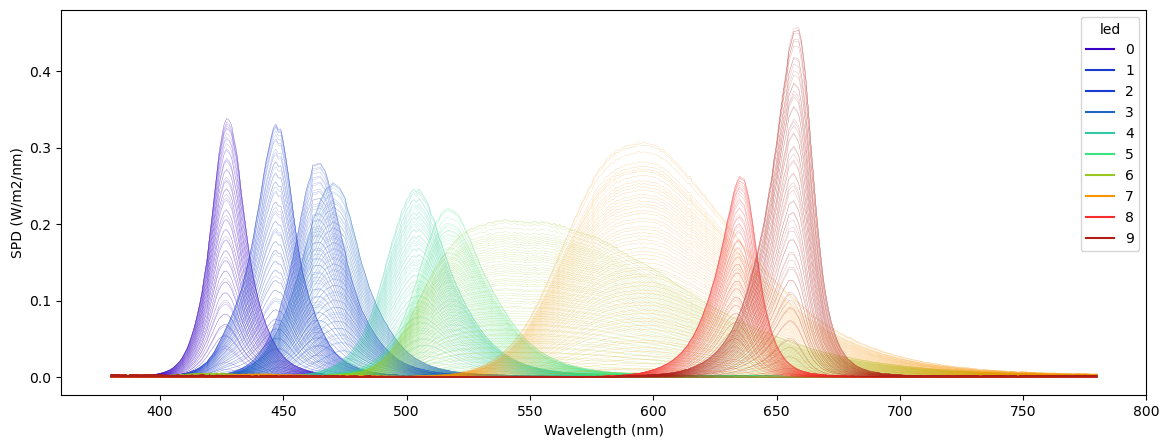

In [3]:
# from pyplr.calibrate import CalibrationContext as calibrationContext
# Calibration - important
import pyplr.calibrate as calb
from importlib import reload
reload(calb)
# file type to be read must be in format of:
# led | intensity | wavelength 1 (380) | wavelength 2 | ... | wavelength n (780)

cc = calb.CalibrationContext(
    'S2_corrected_oo_spectra.csv', binwidth=1)
_ = cc.plot_calibrated_spectra()


In [4]:
# calculate the peak spectral sensitivity for each LED at its maximum intensity setting
cc.lkp.xs(key=4095, level=1).idxmax(axis=1)

led
0    427
1    447
2    465
3    470
4    505
5    517
6    540
7    594
8    635
9    659
dtype: int64

In [5]:
blue_led = 3
red_led = 9
target_lux = 800

# Find the required intensity setting of the blue led for 800 lux
blue_intensity = (cc.lux.loc[blue_led].sub(target_lux)
                                      .abs()
                                      .idxmin())
#                                     .values[0])

# Find the intensity setting of the red led for 800 lux
red_intensity = cc.match(match_led=blue_led,
                         match_led_intensity=blue_intensity,
                         target_led=red_led,
                         match_type='irrad')[1]

C:\Users\kebl6975\Documents\GitHub\cvd_pupillometry\pyplr\CIE.py:5908: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  sss.index = pd.Int64Index(sss.index)


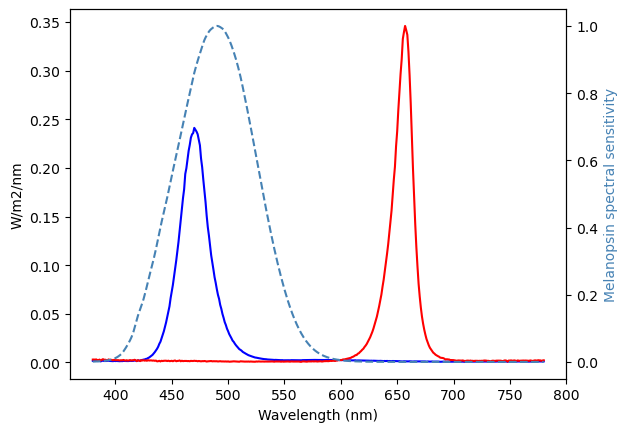

In [6]:
import matplotlib.pyplot as plt
from pyplr.CIE import get_CIES026

fig, ax = plt.subplots()
sss = get_CIES026(binwidth=1)
ax.plot(cc.lkp.loc[(blue_led, blue_intensity)], c='blue')
ax.plot(cc.lkp.loc[(red_led, red_intensity)], c='red')

ax2 = ax.twinx()
ax2.plot(sss['I'], ls='dashed', c='steelblue') # melanopsin = "I"
ax2.set_ylabel('Melanopsin spectral sensitivity', c='steelblue')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('W/m2/nm');

In [7]:
from pyplr import stlab

blue_spec, red_spec = [0]*10, [0]*10
blue_spec[blue_led] = blue_intensity
red_spec[red_led] = red_intensity
d.turn_off()

<Response [200]>

In [8]:
# CHECK 3D MODEL
from time import sleep
# import random # not using this library unless we want to randomize stims
from pyplr.pupil import PupilCore
from pyplr.utils import unpack_data_pandas
from pyplr.protocol import input_subject_id, subject_dir
# Connect to Pupil Core
p = PupilCore()
p.check_3d_model()

> Refit the 3d model? [y/n]: y
> Unfreezing 3d model for eye 0
> Unfreezing 3d model for eye 1
> Ask the participant to roll their eyes
> Press "Enter" when ready to freeze the model: 
> Freezing 3d model for eye 0
> Freezing 3d model for eye 1


Please enter subject ID: 001
> Grabbing 570 seconds of pupil.1.3d> Grabbing 570 seconds of pupil.0.3d

> Waiting for a light to stamp...
> Light stamped on frame.world at -22285.804067
> Waiting for a light to stamp...
> Light stamped on frame.world at -22194.411936
> Waiting for a light to stamp...
> Light stamped on frame.world at -22102.94894
> Waiting for a light to stamp...
> Light stamped on frame.world at -22011.558772
> Waiting for a light to stamp...
> Light stamped on frame.world at -21920.078341
> Waiting for a light to stamp...
> Light stamped on frame.world at -21828.632849999998
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting for futures...
Waiting f

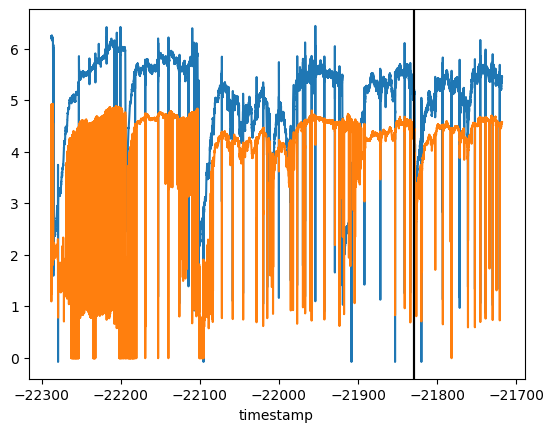

In [9]:
# PIPR STIMS - START
d.turn_off()
subject_id = input_subject_id()
subj_dir = subject_dir(subject_id)
sleep(2)
ISI = 85 # interstimulus time (seconds) = this variable + 5s due to sleep + processing
num_trials = 6 # total number of trials
run_time = ISI*num_trials + 5*num_trials + 30 # appropriate offset to account for stim duration + sleeps


# Start a new recording called "my_recording"
p.command('R my_recording')

# Wait a few seconds
sleep(2)

# Make an annotation for when the light comes on
annotation = p.new_annotation('LIGHT_ON')

# Start the .light_stamper(...) and .pupil_grabber(...)
# this only captures one eye
# pgr_future = p.pupil_grabber(topic='pupil.1.3d', seconds=25) # time here is TOTAL run time
pgr_future_eye1 = p.pupil_grabber(topic='pupil.1.3d', seconds=run_time) # time here is TOTAL run time
pgr_future_eye0 = p.pupil_grabber(topic='pupil.0.3d', seconds=run_time) # time here is TOTAL run time

sleep(2)
##################################
# Administer light stimulus here #
led_list = [3,9]*3
# random.shuffle(led_list) # use this if stims should be randomized
for led in led_list:
    intensities = [0]*10
    if led == 3:
        intensities[led] = int(blue_intensity)
    else:
        intensities[led] = int(red_intensity)
    lst_future = p.light_stamper(annotation=annotation, timeout=10)
    d.set_spectrum_a(intensities)
    sleep(1.)
    d.turn_off()
    sleep(ISI)
    sleep(5) # make sure there is extra time so that trials do not overlap
##################################

# Wait for the futures
while lst_future.running() or pgr_future_eye0.running() or pgr_future_eye1.running():
    print('Waiting for futures...')
    sleep(1)

# End recording
p.command('r')

# Get the timestamp and pupil data
timestamp = lst_future.result()[1]
data_eye0 = unpack_data_pandas(pgr_future_eye0.result())
data_eye1 = unpack_data_pandas(pgr_future_eye1.result())
# timestamps are displayed in the output as well
# Plot the PLR
ax_0 = data_eye0['diameter_3d'].plot()
ax_0.axvline(x=timestamp, color='k')
ax_1 = data_eye1['diameter_3d'].plot()
ax_1.axvline(x=timestamp, color='k')

In [10]:
# display data from pandas table
data_eye0

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
-22287.902707,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.423698954418972, 0.4705391377763515]",64.039585,1.000000,"{'center': [7.9778093289326595, 3.436533341218...","{'center': [157.01346673054198, 122.2655515203...","{'center': [-0.8758237432978877, 0.86814008472...",6.233087,"{'center': [81.35019924844262, 101.65648554694...","[81.35019924844262, 101.65648554694052]",1.0,1.820528,-2.645009
-22287.883130,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.42365142455605903, 0.4707658437137082]",64.065586,0.919433,"{'center': [7.9778093289326595, 3.436533341218...","{'center': [157.01346673054198, 122.2655515203...","{'center': [-0.8766923213453683, 0.86387414164...",6.236195,"{'center': [81.34107351476334, 101.61295800696...","[81.34107351476334, 101.61295800696803]",1.0,1.820951,-2.645390
-22287.862501,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.42378946897898007, 0.47073279907108756]",63.927750,0.937607,"{'center': [7.9778093289326595, 3.436533341218...","{'center': [157.01346673054198, 122.2655515203...","{'center': [-0.8737924482302315, 0.86438194315...",6.221262,"{'center': [81.36757804396417, 101.61930257835...","[81.36757804396417, 101.6193025783512]",1.0,1.820901,-2.644762
-22287.854974,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.42377156143317, 0.471240243064879]",63.908487,0.942139,"{'center': [7.9778093289326595, 3.436533341218...","{'center': [157.01346673054198, 122.2655515203...","{'center': [-0.8739021019696924, 0.85474509840...",6.219813,"{'center': [81.36413979516864, 101.52187333154...","[81.36413979516864, 101.52187333154323]",1.0,1.821858,-2.645237
-22287.838275,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.42369296794344274, 0.47083717579086903]",63.942436,1.000000,"{'center': [7.9778093289326595, 3.436533341218...","{'center': [157.01346673054198, 122.2655515203...","{'center': [-0.8755586903274803, 0.86254398339...",6.223186,"{'center': [81.34904984514101, 101.59926224815...","[81.34904984514101, 101.59926224815314]",1.0,1.821084,-2.645216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-21717.944508,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.3819682475589237, 0.5014323526701556]",55.338788,1.000000,"{'center': [7.9778093289326595, 3.436533341218...","{'center': [157.01346673054198, 122.2655515203...","{'center': [-1.6016339424277906, 0.36714619367...",5.433248,"{'center': [73.33790353131336, 95.724988287330...","[73.33790353131336, 95.7249882873301]",1.0,1.870620,-2.875572
-21717.936009,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.38213743907400605, 0.5008811690270176]",55.417560,1.000000,"{'center': [7.9778093289326595, 3.436533341218...","{'center': [157.01346673054198, 122.2655515203...","{'center': [-1.5992437231874703, 0.37729075469...",5.441074,"{'center': [73.37038830220916, 95.830815546812...","[73.37038830220916, 95.83081554681262]",1.0,1.869599,-2.873507
-21717.924683,0,pupil.0.3d,pye3d 0.3.0 real-time,"[0.3819197917329309, 0.5008866472079434]",55.385029,1.000000,"{'center': [7.9778093289326595, 3.436533341218...","{'center': [157.01346673054198, 122.2655515203...","{'center': [-1.6029566393708077, 0.37785005212...",5.437883,"{'center': [73.32860001272273, 95.829763736074...","[73.32860001272273, 95.82976373607488]",1.0,1.869542,-2.874859


In [11]:
data_eye1

,id,topic,method,norm_pos,diameter,confidence,sphere,projected_sphere,circle_3d,diameter_3d,ellipse,location,model_confidence,theta,phi
timestamp,,,,,,,,,,,,,,,
-22287.908008,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.49300178283481194, 0.7719881052445442]",37.275990,0.239950,"{'center': [2.2962014951921503, -3.63162468835...","{'center': [119.4774696998958, 58.723226247853...","{'center': [0.03000198985857505, -3.0814968453...",1.999867,"{'center': [94.6563423042839, 43.7782837930475...","[94.6563423042839, 43.77828379304751]",1.0,1.517835,-1.790942
-22287.874877,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.46869294160838226, 0.8440653527980371]",36.086571,0.266490,"{'center': [2.2962014951921503, -3.63162468835...","{'center': [119.4774696998958, 58.723226247853...","{'center': [-0.2300178669508921, -3.8653446322...",1.933672,"{'center': [89.9890447888094, 29.9394522627768...","[89.9890447888094, 29.939452262776882]",1.0,1.593288,-1.816405
-22287.842129,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4721836212422739, 0.6500853558595872]",33.418954,0.244013,"{'center': [2.2962014951921503, -3.63162468835...","{'center': [119.4774696998958, 58.723226247853...","{'center': [-0.19511345032741145, -1.792518606...",1.831840,"{'center': [90.6592552785166, 67.1836116749592...","[90.6592552785166, 67.18361167495927]",1.0,1.392891,-1.816843
-22287.805439,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.492744076674232, 0.7723524987621757]",37.581096,0.248365,"{'center': [2.2962014951921503, -3.63162468835...","{'center': [119.4774696998958, 58.723226247853...","{'center': [0.027078149095407067, -3.085355891...",2.016073,"{'center': [94.60686272145254, 43.708320237662...","[94.60686272145254, 43.70832023766227]",1.0,1.518207,-1.791226
-22287.766395,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.4453522072115877, 0.8552587033794554]",40.356311,0.249359,"{'center': [2.2962014951921503, -3.63162468835...","{'center': [119.4774696998958, 58.723226247853...","{'center': [-0.4850722720396603, -3.9994631632...",2.166043,"{'center': [85.50762378462484, 27.790328951144...","[85.50762378462484, 27.79032895114456]",1.0,1.606199,-1.841901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-21717.945029,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.5163690047256274, 0.7212290227758764]",85.212429,0.869448,"{'center': [2.2962014951921503, -3.63162468835...","{'center': [119.4774696998958, 58.723226247853...","{'center': [0.2459750315573097, -2.50312632651...",4.567294,"{'center': [99.14284890732047, 53.524027627031...","[99.14284890732047, 53.52402762703173]",1.0,1.461992,-1.770579
-21717.935667,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.5163131635569623, 0.7215243888307502]",85.179793,0.840336,"{'center': [2.2962014951921503, -3.63162468835...","{'center': [119.4774696998958, 58.723226247853...","{'center': [0.24539980310399434, -2.5063430302...",4.565349,"{'center': [99.13212740293676, 53.467317344495...","[99.13212740293676, 53.46731734449596]",1.0,1.462303,-1.770629
-21717.925512,1,pupil.1.3d,pye3d 0.3.0 real-time,"[0.5164553098287892, 0.7217674202064535]",85.140982,0.844844,"{'center': [2.2962014951921503, -3.63162468835...","{'center': [119.4774696998958, 58.723226247853...","{'center': [0.24698383240081778, -2.5089409021...",4.563004,"{'center': [99.15941948712752, 53.420655320360...","[99.15941948712752, 53.42065532036092]",1.0,1.462555,-1.770467


In [12]:
import os  

# os.makedirs('C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata', exist_ok=True) 

data_eye0.to_csv(path_base + subj_base + '-eye0.csv')
data_eye1.to_csv(path_base + subj_base + '-eye1.csv')

**DATA PROCESSING BEGINS BELOW**

In [13]:
samples_eye0 = data_eye0
samples_eye1 = data_eye1

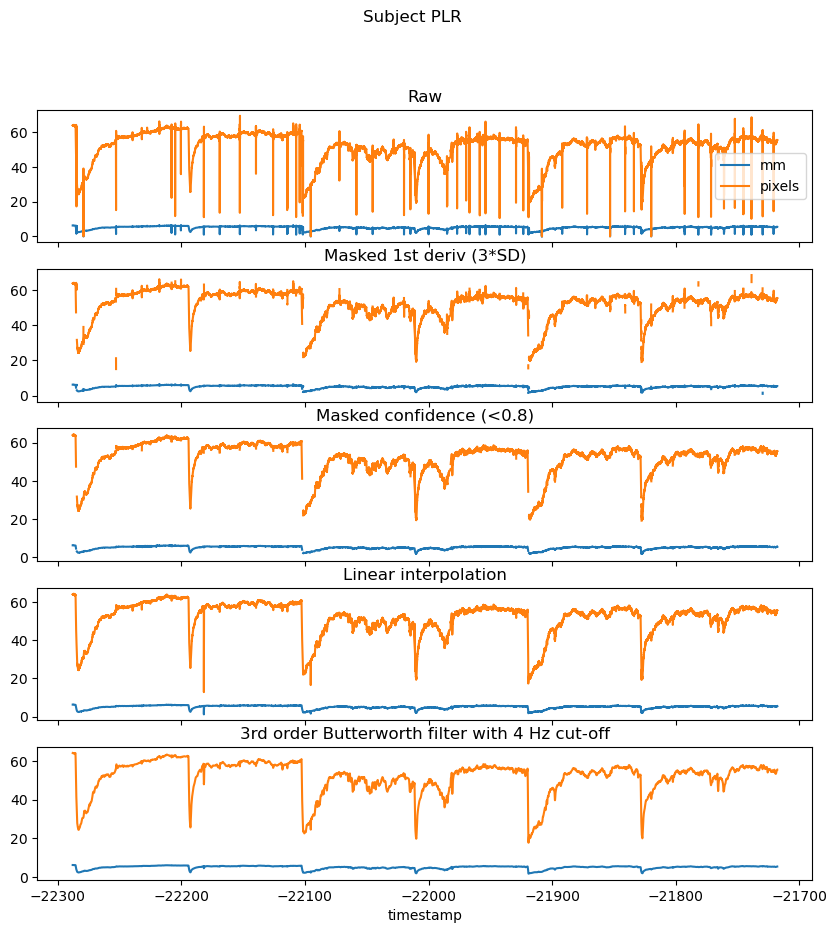

In [14]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [15]:
# export butterworth processed sample data for eye 0
samples_eye0.to_csv(path_base + subj_base + '-butterworth-eye0.csv') # raw data

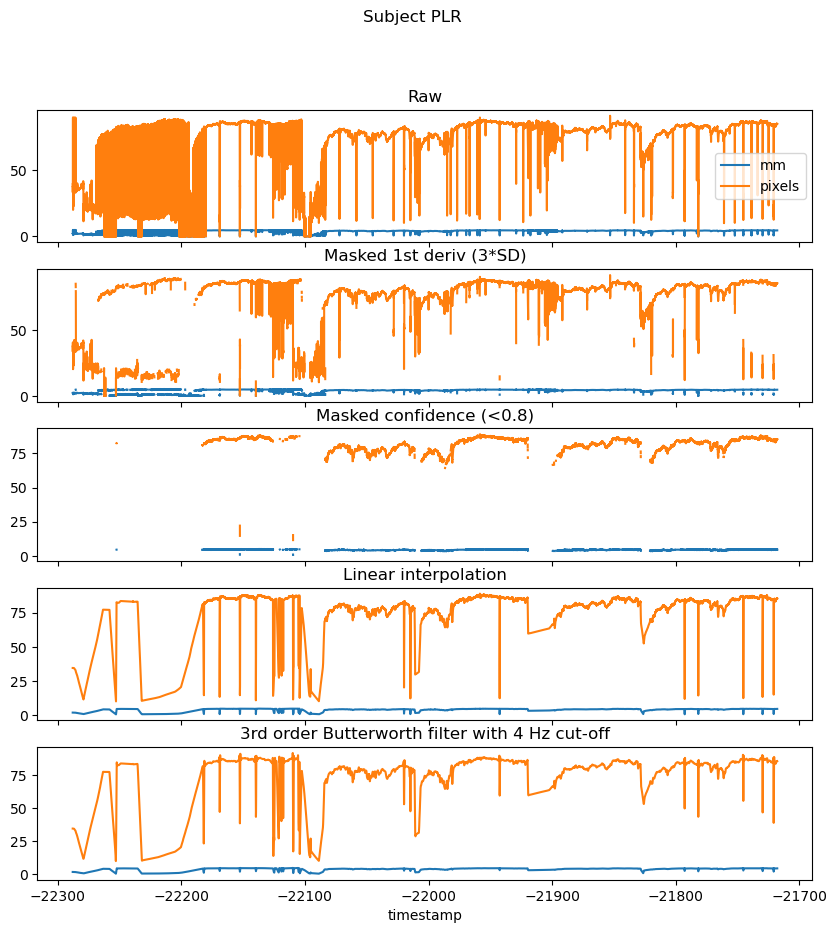

In [16]:
# Sampling frequency
SAMPLE_RATE = 120

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [17]:
# export butterworth processed sample data for eye 1
samples_eye1.to_csv(path_base + subj_base + '-butterworth-eye1.csv') # raw data
# can stop here if necessary

**CAN STOP HERE AND DO ANALYSIS LATER**

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
# df_pipr = pd.read_csv("C:/Users/kebl6975/Documents/GitHub/cvd_pupillometry/subjectdata/sub-999_ses-02_dat-20230419.csv")
df_pipr_eye0 = pd.read_csv(path_base + subj_base + '-eye0.csv')
df_pipr_eye1 = pd.read_csv(path_base + subj_base + '-eye1.csv')

# Print header names
# print(df_pipr.columns)

# Extract the column with header "timestamp"
timestamps_eye0 = df_pipr_eye0["timestamp"]
timestamps_eye1 = df_pipr_eye1["timestamp"]
# Extract the column with header "diameter_3d"
diam_3d_eye0 = df_pipr_eye0["diameter_3d"]
diam_3d_eye1 = df_pipr_eye1["diameter_3d"]

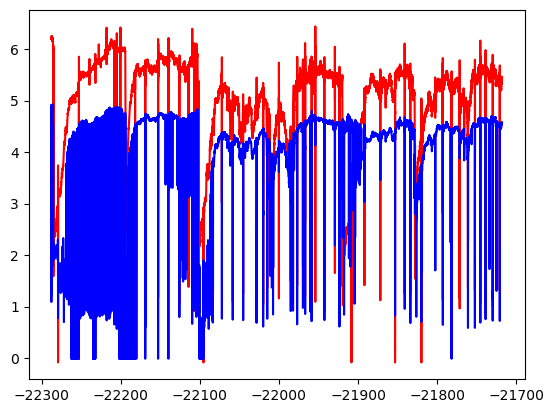

In [21]:
fig = plt.figure()
# plot eye0 in red, eye1 in blue
plt.plot(timestamps_eye0, diam_3d_eye0, 'r') # this should be the smoothed out data - if not, check
plt.plot(timestamps_eye1, diam_3d_eye1, 'b') # this should be the smoothed out data - if not, check

This is copied from the output of cell 11
> Light stamped on frame.world at -22285.804067
> Waiting for a light to stamp...
> Light stamped on frame.world at -22194.411936
> Waiting for a light to stamp...
> Light stamped on frame.world at -22102.94894
> Waiting for a light to stamp...
> Light stamped on frame.world at -22011.558772
> Waiting for a light to stamp...
> Light stamped on frame.world at -21920.078341
> Waiting for a light to stamp...
> Light stamped on frame.world at -21828.632849999998

**Edit Cell Below with Timestamps**

In [22]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye0 <= -22285.804067)[0][-1]
stamp2 = np.where(timestamps_eye0 <= -22194.411936)[0][-1]
stamp3 = np.where(timestamps_eye0 <= -22102.94894)[0][-1]
stamp4 = np.where(timestamps_eye0 <= -22011.558772)[0][-1]
stamp5 = np.where(timestamps_eye0 <= -21920.078341)[0][-1]
stamp6 = np.where(timestamps_eye0 <= -21828.632849999998)[0][-1]
stamps_eye0 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye0

[110, 5124, 12596, 20865, 29187, 37778]

In [23]:
# NEED TO EDIT THIS WITH NEW TIMESTAMPS
# finds indices of each timestamp (or closest one before, if exact match cannot be found).
# finds list of timestamps where condition is true, extracts array of just this, then takes last value (closest stamp)
stamp1 = np.where(timestamps_eye1 <= -22285.804067)[0][-1]
stamp2 = np.where(timestamps_eye1 <= -22194.411936)[0][-1]
stamp3 = np.where(timestamps_eye1 <= -22102.94894)[0][-1]
stamp4 = np.where(timestamps_eye1 <= -22011.558772)[0][-1]
stamp5 = np.where(timestamps_eye1 <= -21920.078341)[0][-1]
stamp6 = np.where(timestamps_eye1 <= -21828.632849999998)[0][-1]
stamps_eye1 = [stamp1, stamp2, stamp3, stamp4, stamp5, stamp6]
stamps_eye1

[61, 4111, 11207, 19309, 27394, 34835]

In [24]:
from pyplr import utils
from copy import deepcopy

In [25]:
df_data_eye0 = df_pipr_eye0[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1 = df_pipr_eye1[['timestamp', 'confidence','id','diameter','diameter_3d']]
df_data_eye1

,timestamp,confidence,id,diameter,diameter_3d
0,-22287.908008,0.239950,1,37.275990,1.999867
1,-22287.874877,0.266490,1,36.086571,1.933672
2,-22287.842129,0.244013,1,33.418954,1.831840
3,-22287.805439,0.248365,1,37.581096,2.016073
4,-22287.766395,0.249359,1,40.356311,2.166043
...,...,...,...,...,...
44824,-21717.945029,0.869448,1,85.212429,4.567294
44825,-21717.935667,0.840336,1,85.179793,4.565349
44826,-21717.925512,0.844844,1,85.140982,4.563004
44827,-21717.916305,0.862962,1,85.199792,4.566460


**Extract ranges from samples based on event timing and sample count, eye 0**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [26]:
samples_eye0 = df_data_eye0
event_starts_eye0 = stamps_eye0
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye0 = (
    np.searchsorted(samples_eye0.index, event_starts_eye0, "left") + offset
)
range_duration = duration

In [27]:
range_idxs_eye0

array([   50,  5064, 12536, 20805, 29127, 37718], dtype=int64)

In [28]:
# make a hierarchical index for eye 0
samples_eye0["orig_idx"] = samples_eye0.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye0))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye0 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye0:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye0):
        end_idx = len(samples_eye0) - 1
    new_df_eye0 = deepcopy(
        samples_eye0.loc[samples_eye0.index[start_idx] : samples_eye0.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye0 = pd.concat([df_eye0, new_df_eye0])
    idx += 1
    
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye0)!= len(midx)):
    df_test = df_eye0
    temp_df = deepcopy(df_eye0.loc[df_eye0.index[-1] : df_eye0.index[-1]])
    while len(df_eye0) != len(midx):
        df_eye0= pd.concat([df_eye0, temp_df])

df_eye0.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye0)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_7936\2141019394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye0["orig_idx"] = samples_eye0.index


In [29]:
df_eye0.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Extract ranges from samples based on event timing and sample count, eye 1**

Adapted from extract() from utils.py. Set variables - change as necessary. 
Note: even though ISI is 120, we only want 60s of post measurement

In [30]:
samples_eye1 = df_data_eye1
event_starts_eye1 = stamps_eye0 # EDIT
onset_time = 1
duration_time = 60
offset = -60*onset_time # 60 sample rate, start 1s before light to get baseline
duration = 60*duration_time  # 60 sample rate

# find the indexes of the event starts, and offset by sample count
range_idxs_eye1 = (
    np.searchsorted(samples_eye1.index, event_starts_eye1, "left") + offset
)
range_duration = duration

In [31]:
range_idxs_eye1

array([   50,  5064, 12536, 20805, 29127, 37718], dtype=int64)

In [32]:
# make a hierarchical index for eye 1
samples_eye1["orig_idx"] = samples_eye1.index
midx = pd.MultiIndex.from_product(
    [list(range(len(event_starts_eye1))), list(range(range_duration))],
    names=["event", "onset"],
)

# TODO: can add option for time index here

# get the samples
df_eye1 = pd.DataFrame()
idx = 0
for start_idx in range_idxs_eye1:
    # get the start time and add the required number of indices
    end_idx = start_idx + range_duration - 1  # .loc indexing is inclusive
    if end_idx >= len(samples_eye1):
        end_idx = len(samples_eye1) - 1
    new_df_eye1 = deepcopy(
        samples_eye1.loc[samples_eye1.index[start_idx] : samples_eye1.index[end_idx]]
    )
    #for ba in borrow_attributes:
        #new_df[ba] = events.iloc[idx].get(ba, float("nan"))
    df_eye1 = pd.concat([df_eye1, new_df_eye1])
    idx += 1
# if there is an error that doesn't allow the new indices to be set (size mismatch), use the if loop below
if (len(df_eye1)!= len(midx)):
    df_test = df_eye1
    temp_df = deepcopy(df_eye1.loc[df_eye1.index[-1] : df_eye1.index[-1]])
    while len(df_eye1) != len(midx):
        df_eye1= pd.concat([df_eye1, temp_df])
df_eye1.index = midx
print("Extracted ranges for {} events".format(len(event_starts_eye1)))

Extracted ranges for 6 events


C:\Users\kebl6975\AppData\Local\Temp\ipykernel_7936\3597893296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_eye1["orig_idx"] = samples_eye1.index


In [33]:
df_eye1.index

MultiIndex([(0,    0),
            (0,    1),
            (0,    2),
            (0,    3),
            (0,    4),
            (0,    5),
            (0,    6),
            (0,    7),
            (0,    8),
            (0,    9),
            ...
            (5, 3590),
            (5, 3591),
            (5, 3592),
            (5, 3593),
            (5, 3594),
            (5, 3595),
            (5, 3596),
            (5, 3597),
            (5, 3598),
            (5, 3599)],
           names=['event', 'onset'], length=21600)

**Re-run the processing on the multi-index data, eye 0**

In [34]:
from pyplr import graphing
from pyplr import preproc
# Calculate baselines
baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye0 = preproc.percent_signal_change(
    df_eye0, baselines_eye0, ['diameter_3d', 'diameter'])
df_eye0

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_7936\4183176285.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye0 = df_eye0.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -22286.971814    0.934095   0  64.020772     6.222285        50   
      1     -22286.951475    0.986228   0  63.983268     6.217697        51   
      2     -22286.932837    1.000000   0  63.955575     6.214370        52   
      3     -22286.920050    1.000000   0  63.970218     6.215405        53   
      4     -22286.899823    0.893263   0  63.969055     6.216051        54   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -21791.303870    1.000000   0  54.274994     5.325064     41313   
      3596  -21791.297532    1.000000   0  54.525081     5.351089     41314   
      3597  -21791.290336    1.000000   0  54.342122     5.332146     41315   
      3598  -21791.282560    1.000000   0  54.642775     5.363539     41316   
      3599  -21791.273759    1.000000   0  54.201463     5.317328     41317   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.525895     0.429398  
      1            0.451763     0.370565  
      2            0.398015     0.327123  
      3            0.414747     0.350095  
      4            0.425171     0.348271  
...                     ...          ...  
5     3595         3.685401     3.186531  
      3596         4.192138     3.661992  
      3597         3.823287     3.314154  
      3598         4.434540     3.885749  
      3599         3.534754     3.046735  

[21600 rows x 8 columns]

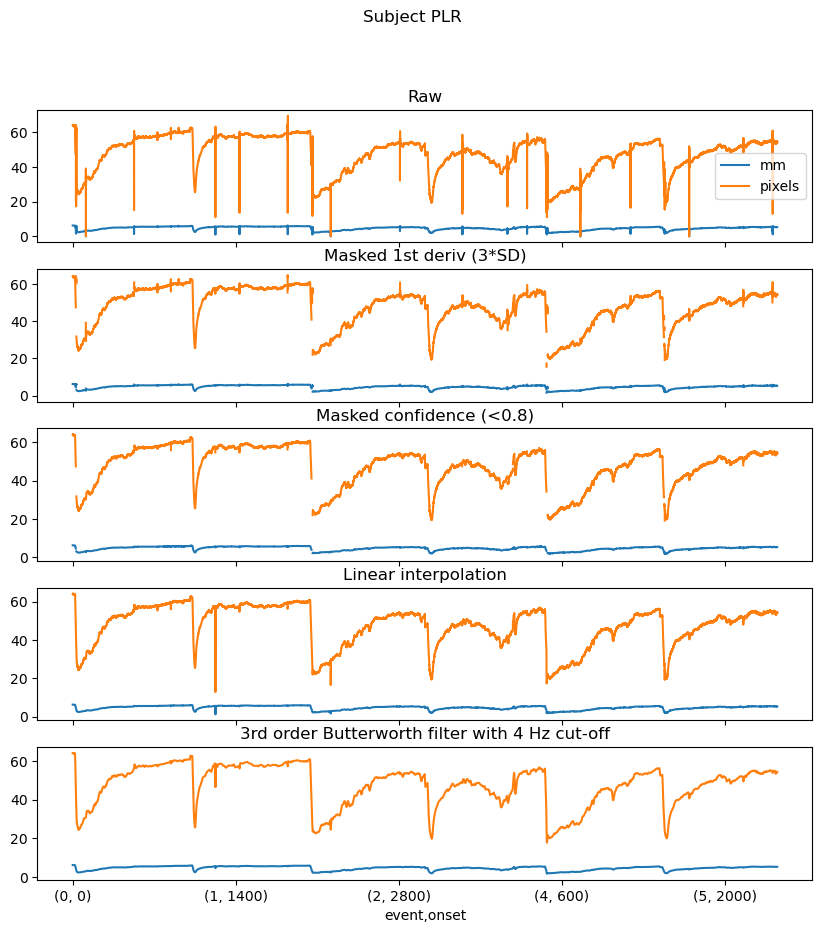

In [35]:
from pyplr import graphing
from pyplr import preproc

# Sampling frequency
SAMPLE_RATE = 120
samples_eye0 = df_eye0

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye0[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye0 = preproc.mask_pupil_first_derivative(
    samples_eye0, threshold=3.0, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye0 = preproc.mask_pupil_confidence(
    samples_eye0, threshold=0.8, mask_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye0 = preproc.interpolate_pupil(
    samples_eye0, interp_cols=pupil_cols)
samples_eye0[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye0 = preproc.butterworth_series(
    samples_eye0, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye0[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [36]:
samples_eye0 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -22286.971814    0.934095   0  64.020434     6.222260        50   
      1     -22286.951475    0.986228   0  64.021922     6.222211        51   
      2     -22286.932837    1.000000   0  64.024446     6.222274        52   
      3     -22286.920050    1.000000   0  64.027792     6.222429        53   
      4     -22286.899823    0.893263   0  64.031697     6.222651        54   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -21791.303870    1.000000   0  54.337376     5.331586     41313   
      3596  -21791.297532    1.000000   0  54.318068     5.329561     41314   
      3597  -21791.290336    1.000000   0  54.297426     5.327396     41315   
      3598  -21791.282560    1.000000   0  54.276306     5.325180     41316   
      3599  -21791.273759    1.000000   0  54.255546     5.323001     41317   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0            0.525895     0.429398             0  
      1            0.451763     0.370565             0  
      2            0.398015     0.327123             0  
      3            0.414747     0.350095             0  
      4            0.425171     0.348271             0  
...                     ...          ...           ...  
5     3595         3.685401     3.186531             0  
      3596         4.192138     3.661992             0  
      3597         3.823287     3.314154             0  
      3598         4.434540     3.885749             0  
      3599         3.534754     3.046735             0  

[21600 rows x 9 columns]

In [37]:
df_eye0

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -22286.971814    0.934095   0  64.020772     6.222285        50   
      1     -22286.951475    0.986228   0  63.983268     6.217697        51   
      2     -22286.932837    1.000000   0  63.955575     6.214370        52   
      3     -22286.920050    1.000000   0  63.970218     6.215405        53   
      4     -22286.899823    0.893263   0  63.969055     6.216051        54   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -21791.303870    1.000000   0  54.274994     5.325064     41313   
      3596  -21791.297532    1.000000   0  54.525081     5.351089     41314   
      3597  -21791.290336    1.000000   0  54.342122     5.332146     41315   
      3598  -21791.282560    1.000000   0  54.642775     5.363539     41316   
      3599  -21791.273759    1.000000   0  54.201463     5.317328     41317   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0            0.525895     0.429398  
      1            0.451763     0.370565  
      2            0.398015     0.327123  
      3            0.414747     0.350095  
      4            0.425171     0.348271  
...                     ...          ...  
5     3595         3.685401     3.186531  
      3596         4.192138     3.661992  
      3597         3.823287     3.314154  
      3598         4.434540     3.885749  
      3599         3.534754     3.046735  

[21600 rows x 8 columns]

**Re-run processing on multi-index data, eye 1**

In [38]:
# Calculate baselines
baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)

# New columns for percent signal change
df_eye1 = preproc.percent_signal_change(
    df_eye1, baselines_eye1, ['diameter_3d', 'diameter'])
df_eye1

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_7936\1788001868.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  baselines_eye1 = df_eye1.loc[:, range(0, -offset), :].mean(level=0)


timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -22286.235981    0.268776   1  35.382917     1.928104        50   
      1     -22286.197323    0.284433   1  35.482810     1.933470        51   
      2     -22286.164266    0.246750   1  37.528165     2.015039        52   
      3     -22286.142062    0.246602   1  37.551098     2.016266        53   
      4     -22286.106317    0.728838   1  88.817146     4.852967        54   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -21755.754471    0.878139   1  84.030852     4.482059     41313   
      3596  -21755.745143    0.869942   1  83.822990     4.471433     41314   
      3597  -21755.730467    0.838777   1  83.835074     4.472228     41315   
      3598  -21755.721906    0.876722   1  83.900230     4.475656     41316   
      3599  -21755.711854    0.894067   1  83.860848     4.473857     41317   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0          -22.701469   -22.865485  
      1          -22.486309   -22.647719  
      2          -19.216192   -18.188859  
      3          -19.166986   -18.138864  
      4           94.557597    93.620767  
...                     ...          ...  
5     3595        -0.231214    -0.000798  
      3596        -0.467742    -0.248160  
      3597        -0.450046    -0.233780  
      3598        -0.373727    -0.156242  
      3599        -0.413790    -0.203108  

[21600 rows x 8 columns]

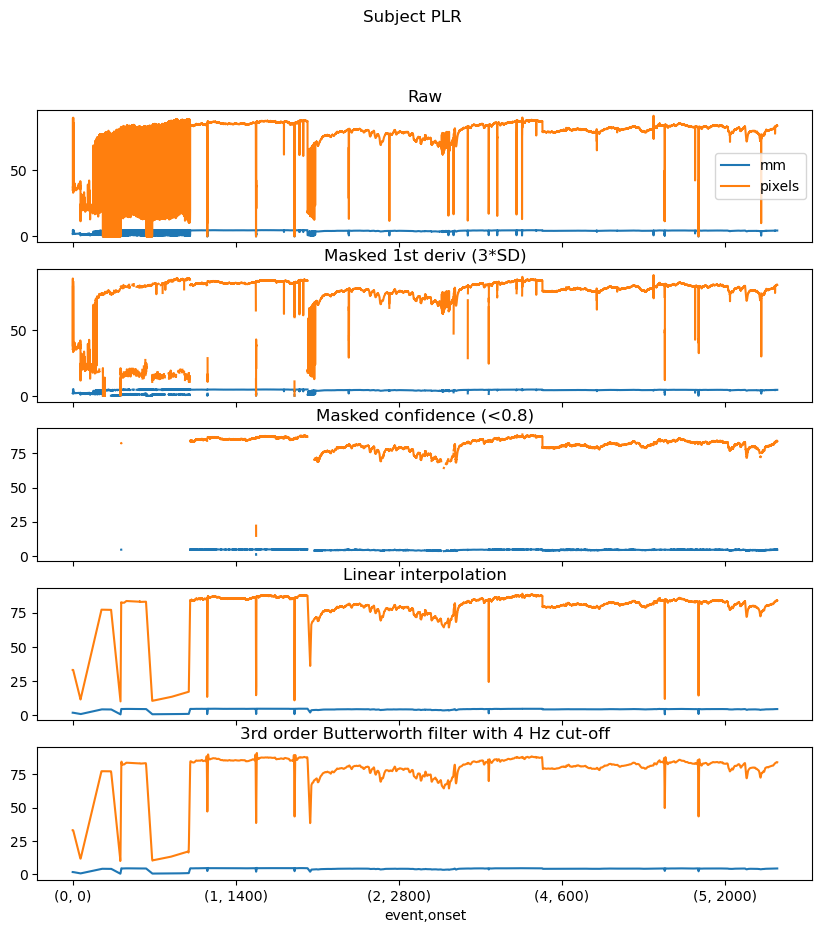

In [39]:
# Sampling frequency
SAMPLE_RATE = 120
samples_eye1 = df_eye1

# Pupil columns to analyse
pupil_cols = ['diameter_3d', 'diameter']

# Make figure for processing
#f, axs = graphing.pupil_preprocessing(nrows=4, subject='Example')
fig, axs = plt.subplots(5, sharex=True, figsize=(10,10))
fig.suptitle('Subject PLR')

# Plot the raw data
samples_eye1[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['mm', 'pixels'])

# Mask first derivative
samples_eye1 = preproc.mask_pupil_first_derivative(
    samples_eye1, threshold=3.0, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples_eye1 = preproc.mask_pupil_confidence(
    samples_eye1, threshold=0.8, mask_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)

# Interpolate
samples_eye1 = preproc.interpolate_pupil(
    samples_eye1, interp_cols=pupil_cols)
samples_eye1[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples_eye1 = preproc.butterworth_series(
    samples_eye1, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples_eye1[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

In [40]:
samples_eye1 # this now has the processed data with blinks removed
# where confidence < 0.8, it interpolates the data
# need to run these to improve the outputs
# TODO: double check what df is after this processing

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -22286.235981    0.268776   1  33.114027     1.799615        50   
      1     -22286.197323    0.284433   1  33.119098     1.799855        51   
      2     -22286.164266    0.246750   1  33.123507     1.800064        52   
      3     -22286.142062    0.246602   1  33.126831     1.800221        53   
      4     -22286.106317    0.728838   1  33.128586     1.800304        54   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -21755.754471    0.878139   1  83.932190     4.477204     41313   
      3596  -21755.745143    0.869942   1  83.919651     4.476703     41314   
      3597  -21755.730467    0.838777   1  83.907016     4.476181     41315   
      3598  -21755.721906    0.876722   1  83.894648     4.475657     41316   
      3599  -21755.711854    0.894067   1  83.882883     4.475148     41317   

             diameter_3d_pc  diameter_pc  interpolated  
event onset                                             
0     0          -22.701469   -22.865485             1  
      1          -22.486309   -22.647719             1  
      2          -19.216192   -18.188859             1  
      3          -19.166986   -18.138864             1  
      4           94.557597    93.620767             1  
...                     ...          ...           ...  
5     3595        -0.231214    -0.000798             0  
      3596        -0.467742    -0.248160             0  
      3597        -0.450046    -0.233780             0  
      3598        -0.373727    -0.156242             0  
      3599        -0.413790    -0.203108             0  

[21600 rows x 9 columns]

In [41]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  orig_idx  \
event onset                                                                   
0     0     -22286.235981    0.268776   1  35.382917     1.928104        50   
      1     -22286.197323    0.284433   1  35.482810     1.933470        51   
      2     -22286.164266    0.246750   1  37.528165     2.015039        52   
      3     -22286.142062    0.246602   1  37.551098     2.016266        53   
      4     -22286.106317    0.728838   1  88.817146     4.852967        54   
...                   ...         ...  ..        ...          ...       ...   
5     3595  -21755.754471    0.878139   1  84.030852     4.482059     41313   
      3596  -21755.745143    0.869942   1  83.822990     4.471433     41314   
      3597  -21755.730467    0.838777   1  83.835074     4.472228     41315   
      3598  -21755.721906    0.876722   1  83.900230     4.475656     41316   
      3599  -21755.711854    0.894067   1  83.860848     4.473857     41317   

             diameter_3d_pc  diameter_pc  
event onset                               
0     0          -22.701469   -22.865485  
      1          -22.486309   -22.647719  
      2          -19.216192   -18.188859  
      3          -19.166986   -18.138864  
      4           94.557597    93.620767  
...                     ...          ...  
5     3595        -0.231214    -0.000798  
      3596        -0.467742    -0.248160  
      3597        -0.450046    -0.233780  
      3598        -0.373727    -0.156242  
      3599        -0.413790    -0.203108  

[21600 rows x 8 columns]

**Convert the index-level samples to time (s)**:

In [42]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye0.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye0.index = df_eye0.index.set_levels(
    levels=new_onset, level='onset')

In [43]:
df_eye0["colour"] = ""

In [44]:
for (event, onset) in df_eye0.index:
    if event%2==1:
        df_eye0["colour"][event,onset] = "red"
    else:
        df_eye0["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_7936\1670583221.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_7936\1670583221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye0["colour"][event,onset] = "red"


In [45]:
ONSET_IDX = 60
SAMPLE_RATE = 60
new_onset = (df_eye1.index.get_level_values('onset')
                    .unique()
            - ONSET_IDX) / SAMPLE_RATE
df_eye1.index = df_eye1.index.set_levels(
    levels=new_onset, level='onset')

In [46]:
df_eye1["colour"] = ""

In [47]:
for (event, onset) in df_eye1.index:
    if event%2==1:
        df_eye1["colour"][event,onset] = "red"
    else:
        df_eye1["colour"][event,onset] = "blue"

C:\Users\kebl6975\AppData\Local\Temp\ipykernel_7936\2599913087.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "blue"
C:\Users\kebl6975\AppData\Local\Temp\ipykernel_7936\2599913087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eye1["colour"][event,onset] = "red"


**Plot the PIPR:**

Text(0.5, 1.0, 'Subject = 1')

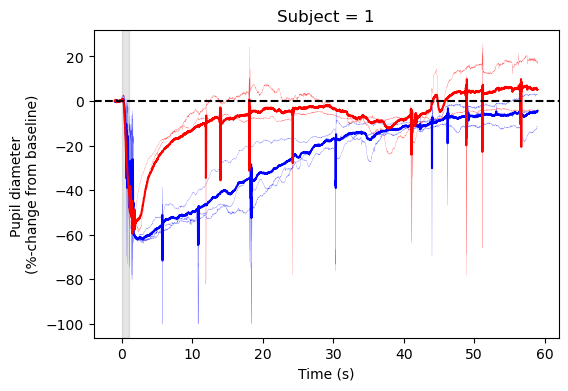

In [50]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye0.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye0 = (df_eye0.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye0, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(subject_id))

In [51]:
import os
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + 'pipr-90s-binoc-sub-001_ses-01_dat-20230811' + '-eye0.png')

In [52]:
df_eye0 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                              
0     -1.000000  -22286.971814    0.934095   0  64.020772     6.222285   
      -0.983333  -22286.951475    0.986228   0  63.983268     6.217697   
      -0.966667  -22286.932837    1.000000   0  63.955575     6.214370   
      -0.950000  -22286.920050    1.000000   0  63.970218     6.215405   
      -0.933333  -22286.899823    0.893263   0  63.969055     6.216051   
...                        ...         ...  ..        ...          ...   
5      58.916667 -21791.303870    1.000000   0  54.274994     5.325064   
       58.933333 -21791.297532    1.000000   0  54.525081     5.351089   
       58.950000 -21791.290336    1.000000   0  54.342122     5.332146   
       58.966667 -21791.282560    1.000000   0  54.642775     5.363539   
       58.983333 -21791.273759    1.000000   0  54.201463     5.317328   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         50        0.525895     0.429398   blue  
      -0.983333         51        0.451763     0.370565   blue  
      -0.966667         52        0.398015     0.327123   blue  
      -0.950000         53        0.414747     0.350095   blue  
      -0.933333         54        0.425171     0.348271   blue  
...                    ...             ...          ...    ...  
5      58.916667     41313        3.685401     3.186531    red  
       58.933333     41314        4.192138     3.661992    red  
       58.950000     41315        3.823287     3.314154    red  
       58.966667     41316        4.434540     3.885749    red  
       58.983333     41317        3.534754     3.046735    red  

[21600 rows x 9 columns]

In [53]:
df_eye0.to_csv(path_base + subj_base + '-processed-eye0.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

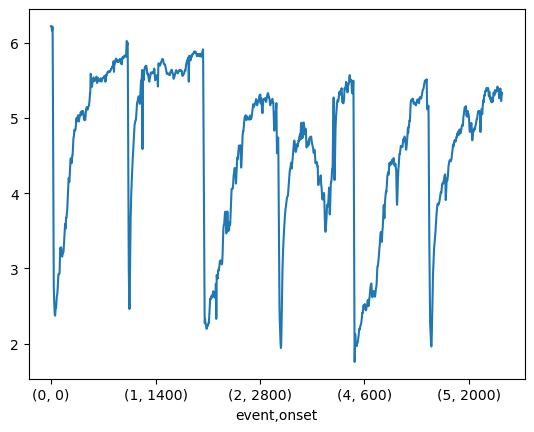

In [54]:
samples_eye0["diameter_3d"].plot()

In [55]:
avgs_eye0.to_csv(path_base + subj_base + '-average-pipr-eye0.csv') # processed data with adjusted onset indices (time in seconds)

In [56]:
df_eye1

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                              
0     -1.000000  -22286.235981    0.268776   1  35.382917     1.928104   
      -0.983333  -22286.197323    0.284433   1  35.482810     1.933470   
      -0.966667  -22286.164266    0.246750   1  37.528165     2.015039   
      -0.950000  -22286.142062    0.246602   1  37.551098     2.016266   
      -0.933333  -22286.106317    0.728838   1  88.817146     4.852967   
...                        ...         ...  ..        ...          ...   
5      58.916667 -21755.754471    0.878139   1  84.030852     4.482059   
       58.933333 -21755.745143    0.869942   1  83.822990     4.471433   
       58.950000 -21755.730467    0.838777   1  83.835074     4.472228   
       58.966667 -21755.721906    0.876722   1  83.900230     4.475656   
       58.983333 -21755.711854    0.894067   1  83.860848     4.473857   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         50      -22.701469   -22.865485   blue  
      -0.983333         51      -22.486309   -22.647719   blue  
      -0.966667         52      -19.216192   -18.188859   blue  
      -0.950000         53      -19.166986   -18.138864   blue  
      -0.933333         54       94.557597    93.620767   blue  
...                    ...             ...          ...    ...  
5      58.916667     41313       -0.231214    -0.000798    red  
       58.933333     41314       -0.467742    -0.248160    red  
       58.950000     41315       -0.450046    -0.233780    red  
       58.966667     41316       -0.373727    -0.156242    red  
       58.983333     41317       -0.413790    -0.203108    red  

[21600 rows x 9 columns]

Text(0.5, 1.0, 'Subject = 1')

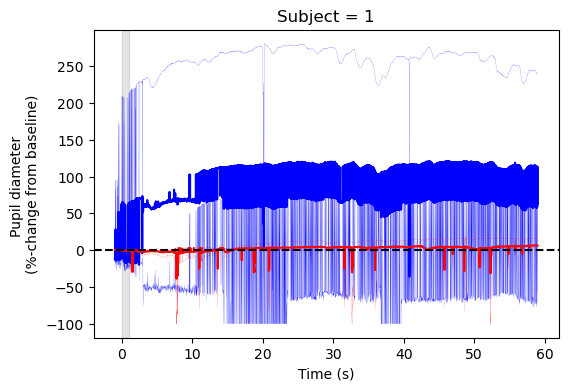

In [57]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
for r in range(5):
    if (r==0 or r%2==0):
        c = 'blue'
    else:
        c = 'red'
    df_eye1.loc[r, 'diameter_pc'].plot(
        color=c, lw='.1', ax=ax, legend=False)

# Now show the means
avgs_eye1 = (df_eye1.reset_index()
                .groupby(['colour','onset'], as_index=False)
                .mean())
sns.lineplot(data=avgs_eye1, x='onset', y='diameter_pc', hue='colour',
                palette={'blue':'b','red':'r'}, legend=False)

# Tweak figures
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
ax.set_title('Subject = {}'.format(df_eye1['id'][0][0]))

In [58]:
if not os.path.exists(path_base + 'figures'):
    os.makedirs(path_base + 'figures')
# Save the figure in the folder
fig.savefig(path_base + 'figures/' + 'pipr-90s-binoc-sub-001_ses-01_dat-20230811' + '-eye1.png')

In [59]:
df_eye1 # check all is as expected before sending to csv

timestamp  confidence  id   diameter  diameter_3d  \
event onset                                                              
0     -1.000000  -22286.235981    0.268776   1  35.382917     1.928104   
      -0.983333  -22286.197323    0.284433   1  35.482810     1.933470   
      -0.966667  -22286.164266    0.246750   1  37.528165     2.015039   
      -0.950000  -22286.142062    0.246602   1  37.551098     2.016266   
      -0.933333  -22286.106317    0.728838   1  88.817146     4.852967   
...                        ...         ...  ..        ...          ...   
5      58.916667 -21755.754471    0.878139   1  84.030852     4.482059   
       58.933333 -21755.745143    0.869942   1  83.822990     4.471433   
       58.950000 -21755.730467    0.838777   1  83.835074     4.472228   
       58.966667 -21755.721906    0.876722   1  83.900230     4.475656   
       58.983333 -21755.711854    0.894067   1  83.860848     4.473857   

                  orig_idx  diameter_3d_pc  diameter_pc colour  
event onset                                                     
0     -1.000000         50      -22.701469   -22.865485   blue  
      -0.983333         51      -22.486309   -22.647719   blue  
      -0.966667         52      -19.216192   -18.188859   blue  
      -0.950000         53      -19.166986   -18.138864   blue  
      -0.933333         54       94.557597    93.620767   blue  
...                    ...             ...          ...    ...  
5      58.916667     41313       -0.231214    -0.000798    red  
       58.933333     41314       -0.467742    -0.248160    red  
       58.950000     41315       -0.450046    -0.233780    red  
       58.966667     41316       -0.373727    -0.156242    red  
       58.983333     41317       -0.413790    -0.203108    red  

[21600 rows x 9 columns]

In [60]:
df_eye1.to_csv(path_base + subj_base + '-processed-eye1.csv') # processed data with adjusted onset indices (time in seconds)

<AxesSubplot: xlabel='event,onset'>

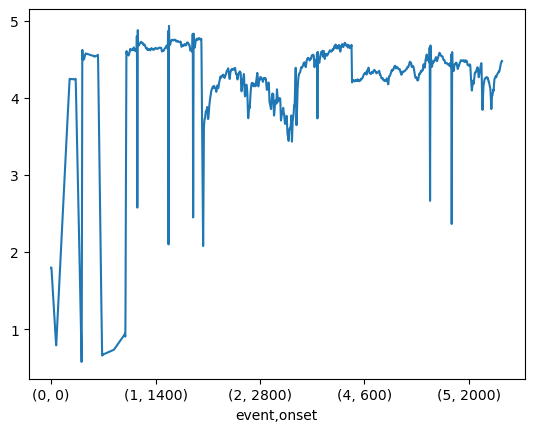

In [61]:
samples_eye1["diameter_3d"].plot()

In [62]:
avgs_eye1.to_csv(path_base + subj_base + '-average-pipr-eye1.csv') # processed data with adjusted onset indices (time in seconds)

**Compute the pupillary light response (optional, skip for now):**

In [ ]:
# adapt this to separate red and blue
from pyplr.plr import PLR

average_plr = df.mean(level=1)['diameter_3d'].to_numpy()
plr = PLR(average_plr,
          sample_rate=60,
          onset_idx=-offset,
          stim_duration=1)

In [ ]:
fig = plr.plot(vel=True, acc=True, print_params=True)

In [ ]:
params = plr.parameters()
params

**Compute the PIPR:**

In [63]:
# code to calculate PIPR at given time
pipr_time = 7 # measure PIPR at t=7s (6s after stimulus turned off)
print(avgs_eye0.loc[avgs_eye0["onset"] == pipr_time])
print(avgs_eye1.loc[avgs_eye1["onset"] == pipr_time])

     colour  onset  event     timestamp  confidence   id   diameter  \
480    blue    7.0    2.0 -22097.042048         1.0  0.0  28.473167   
4080    red    7.0    3.0 -22005.988561         1.0  0.0  44.203262   

      diameter_3d      orig_idx  diameter_3d_pc  diameter_pc  
480      2.748998  14384.333333      -52.808857   -52.428537  
4080     4.260341  21675.666667      -18.800498   -18.337168  
     colour  onset  event     timestamp  confidence   id   diameter  \
480    blue    7.0    2.0 -22079.364457    0.658551  1.0  58.751521   
4080    red    7.0    3.0 -21982.167280    0.851115  1.0  79.757491   

      diameter_3d      orig_idx  diameter_3d_pc  diameter_pc  
480      3.253468  14384.333333       69.624565    66.431482  
4080     4.288609  21675.666667       -2.094777    -2.028428  


In [64]:
# eye 0
blue_d_pipr_eye0 = avgs_eye0["diameter_3d"][480]
red_d_pipr_eye0 = avgs_eye0["diameter_3d"][4080]
blue_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][480]
red_d_pipr_pc_eye0 = avgs_eye0["diameter_3d_pc"][4080]
pipr_diff_eye0 = red_d_pipr_eye0 - blue_d_pipr_eye0
pipr_pc_diff_eye0 = red_d_pipr_pc_eye0 - blue_d_pipr_pc_eye0
print("PIPR (Absolute Difference), Eye 0: ", pipr_diff_eye0)
print("PIPR (Percent Change), Eye 0: ", pipr_pc_diff_eye0)

PIPR (Absolute Difference), Eye 0:  1.5113435996130211
PIPR (Percent Change), Eye 0:  34.00835895049393


In [65]:
# eye 1
blue_d_pipr_eye1 = avgs_eye1["diameter_3d"][480]
red_d_pipr_eye1 = avgs_eye1["diameter_3d"][4080]
blue_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][480]
red_d_pipr_pc_eye1 = avgs_eye1["diameter_3d_pc"][4080]
pipr_diff_eye1 = red_d_pipr_eye1 - blue_d_pipr_eye1
pipr_pc_diff_eye1 = red_d_pipr_pc_eye1 - blue_d_pipr_pc_eye1
print("PIPR (Absolute Difference), Eye 1: ", pipr_diff_eye1)
print("PIPR (Percent Change), Eye 1: ", pipr_pc_diff_eye1)

PIPR (Absolute Difference), Eye 1:  1.0351404788967833
PIPR (Percent Change), Eye 1:  -71.71934221654844
